In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



d:\ads_enfit


In [2]:
from libs.common import *
from config.config import *

d:\ads_enfit\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
# checkpoint_callback = ModelCheckpoint(
#     filepath='best_model_cnn_mlps_no_weights.weights.h5',  # Đường dẫn để lưu model
#     monitor='val_loss',  # Theo dõi val_loss
#     mode='min',
#     save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
#     verbose=1,  # Hiển thị thông báo khi lưu model
#     save_format="tf"
# )

In [10]:
class CNNEncoding:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.features = None
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Conv1D(32, 3, activation='selu')(inputs)
        self.features = MaxPooling1D(2)(x)
        x = Flatten()(self.features)
        x = Dense(1024, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(512, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(256, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(64, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(32, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        
        output = Dense(1, activation='linear')(x)
        
        model = Model(inputs, output, name='model1')
        return model
input_shape=(len(X.columns),1)
cnn_model=CNNEncoding(input_shape=input_shape)
# cnn_model.model.load_weights('weights/cnn.hdf5')
cnn_model.model.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 102, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,321,793 (8.86 MB)

 Trainable params: 2,318,017 (8.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [11]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
class MLPsClassification:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x=GlobalMaxPooling1D()(inputs)
        x = Dense(units=16, activation='relu')(x)
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(units=1, activation='linear')(x)
        model = Model(inputs, outputs, name='model2')
        return model
input_dim=(50,32)

mlps_classification = MLPsClassification(input_shape=input_dim)
mlps_classification.model.summary()

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 32 (128.00 B)

In [12]:
# mlps_classification.model.load_weights('weights/mlps.hdf5')


In [13]:
class CNN_MLPs:
    def __init__(self, input_shape,encoder, classification, lr=0.0001):
        self.input_shape = input_shape
        self.model1 = encoder.model
        self.feature_shape = (encoder.features.shape[1],)
        self.features=encoder.features
        self.model2 = classification.model
        self.lr = lr
        self.model = self.build_model()
        
    def build_model(self):
        combined_input = self.model1.input
        output = self.model2(self.features)
        combined_model = Model(inputs=combined_input, outputs=output, name='combined_model')
        combined_model.compile(optimizer=Adam(learning_rate=self.lr), loss='mae', metrics=['mae', r2])
        return combined_model

In [14]:
model =CNN_MLPs(input_shape=input_shape,encoder=cnn_model, classification=mlps_classification).model
model.summary()


Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 102, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model2 (Functional)             │ (None, 1)              │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 32 (128.00 B)

In [15]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler])

Epoch 1/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.4826 - mae: 0.4826 - r2: -3.7439 - val_loss: 0.2287 - val_mae: 0.2287 - val_r2: 0.5305 - learning_rate: 1.0000e-04
Epoch 2/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.2633 - mae: 0.2633 - r2: 0.1249 - val_loss: 0.2373 - val_mae: 0.2373 - val_r2: 0.5040 - learning_rate: 1.0000e-04
Epoch 3/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.2629 - mae: 0.2629 - r2: 0.1407 - val_loss: 0.2410 - val_mae: 0.2410 - val_r2: 0.4887 - learning_rate: 1.0000e-04
Epoch 4/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 0.2685 - mae: 0.2685 - r2: 0.1567 - val_loss: 0.2374 - val_mae: 0.2374 - val_r2: 0.4997 - learning_rate: 1.0000e-04
Epoch 5/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 0.2640 - mae: 0.2640 - r2: 0.1316 - val_loss: 0.2412 - val_mae: 0.2412 - val_r2: 0.4651 - learning_rate: 1.0000e-04
Epoch 6/10000
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.2665 - ma

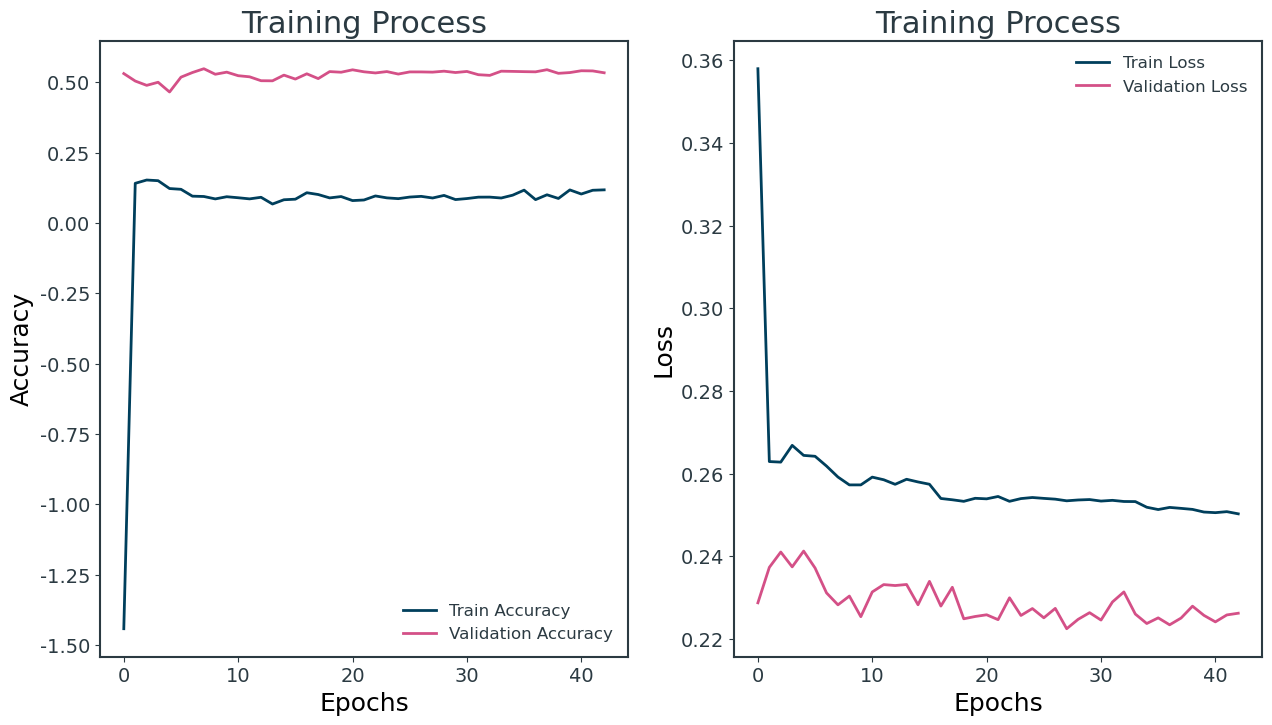

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [17]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'learning_rate'])
[0.3579697012901306, 0.2629106342792511, 0.26277440786361694, 0.26682963967323303, 0.26440176367759705, 0.2641873359680176, 0.2618195414543152, 0.25916770100593567, 0.2572617530822754, 0.25726354122161865, 0.25914281606674194, 0.25850796699523926, 0.2574020028114319, 0.25862574577331543, 0.257978230714798, 0.25742092728614807, 0.25397568941116333, 0.25366225838661194, 0.25328344106674194, 0.254020631313324, 0.25388863682746887, 0.2544601559638977, 0.25328895449638367, 0.2539506256580353, 0.2542131841182709, 0.25399890542030334, 0.2538124918937683, 0.2534128427505493, 0.25361502170562744, 0.25371620059013367, 0.2533494532108307, 0.25352683663368225, 0.253249853849411, 0.2532254457473755, 0.25185731053352356, 0.2512984871864319, 0.25181522965431213, 0.25158432126045227, 0.25133389234542847, 0.2506940960884094, 0.25054535269737244, 0.25078728795051575, 0.2502615749835968]
[0.22873197495937347, 0.23730199038

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)
print(y_valid.shape,y_pred.shape)
# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")




16729/16729 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
(535312, 1) (535312, 1)
R2 Score: 0.7279666662216187
MAE: 0.22246006054414352
